- detect neuron assemblies with spectral graph clustering
- julian moran
- 2022-06-01

In [2]:
import os
import math
import warnings
import sys
from pathlib import Path
from itertools import chain
from scipy import spatial
from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [3]:
##########define helper functions##############################

# define cluster colouring helper function
'''
colourClusters()
@desc
    colour graph nodes by cluster membership and return time indices for each cluster
@args
    nodes; ndarray of int
        array of 0:n_nodes; reflects default node-labelling behaviour by networkx
    numClusters; int
        number of clusters
    colours; ndarray of int
        int-labelled array of clusters w/ len(colours) == n_nodes
    colourNames; list of str
        list of colour names to be used for each cluster; suggest tab10 or xckd colours
    timeIndices; ndarray of num
        array of time indices included in the time-nodal graph as per threshold
        order matches colours, nodes, so can be used to pull time-index information for each cluster
        e.g. timeIndices = graph_nodes_counts[0]
'''
def colourClusters(nodes, numClusters, colours, colourNames, timeIndices):

    temp = []

    for i in range(numClusters):
        cluster = nodes[np.where(colours == i, True, False)]
        cluster_timeIndices = timeIndices[np.where(colours == i, True, False)]
        temp.append(cluster_timeIndices)
        nx.draw_networkx_nodes(G, pos, node_color=colourNames[i],  nodelist=cluster, alpha=0.5, node_size=800)

    return temp


# define spectral clustering helper function
def SGC(A, numClusters):
    # compute degree matrix, laplacian
    D = np.diag(A.sum(axis=1))
    L = D - A

    # compute eigenvectors and eigenvalues of laplacian; sort by eigenvalues
    vals, vecs = np.linalg.eig(L)
    vecs = vecs[:, np.argsort(vals)] # np.argsort() returns indices of sorted elements
    vals = vals[np.argsort(vals)]

    # from first n eigenvectors, cluster vector elements into n groups
    #       - each eigenvector binarises the elements into +ve and -ve based on which component they should be grouped into
    #       - KMeans is clustering the vector elements
    kmeans = KMeans(n_clusters=numClusters)
    kmeans.fit(vecs[:, 1:int(numClusters)]) # @juli: originally typed as 1:4 when 4 clusters; what does this line do? 
    colours = kmeans.labels_

    print("Clusters:", colours)
    return colours

In [4]:
##########read in and trim the data##############################

# set numpy print options so as to display full arrays
np.set_printoptions(threshold=sys.maxsize)


# read in the data
path = 'C://Users//julia//OneDrive//documents//MSc_UToronto_thesis//project_PNCI_pipeline//data//meiZ_2019-10-31_unc-13(s69);unc-2(hp647)hpIs675animal_6run_1//_analysis//2022-01-21_plots_se=V3_& IEsManRemd'
fileName = 'debleached_traces.npy'
filePath_data = Path(path + '//' + fileName)

traces = np.load(filePath_data) #traces is an array with shape (n_channels, n_neurons, n_volumes), with traces[1] being GCaMP channel


# read in neuron names in order-preserved format
fileName = 'neuron_names.txt'
filePath_neurNames = Path(path + '//' + fileName)

trace_names = list()
f = open(filePath_neurNames, 'r')

for line in f:
    trace_names.append(line.strip())


# find out how many traces do not contain all-zeros for initializing a new trimmed array
count_nonZeros = 0

for i in range(1, len(traces[1,])):

    if np.nonzero(traces[1, i])[0].size != 0:
        count_nonZeros += 1


message = 'after trimming out traces containing only nan, ' + str(count_nonZeros) + ' traces remain'
print(message)


# trim all those traces that contain only zeros
traces_trimmed = np.zeros((count_nonZeros, np.shape(traces)[2]), dtype='float64')
trace_names_trimmed = list()
count_temp = 0

for i in range(1, len(traces[1,])):
    
    if np.nonzero(traces[1, i])[0].size != 0:
        traces_trimmed[count_temp, :] = traces[1, i]        
        trace_names_trimmed.append(trace_names[i])
        count_temp += 1

print(trace_names_trimmed)

after trimming out traces containing only nan, 144 traces remain
['I6', 'M2L', 'I5', 'I4', 'M2R', 'M1', 'Na56', 'I1R', 'I2R', 'NSMR', 'MCR', 'MCL', 'NSML', 'I2L', 'M1/I3', 'M3R', 'M4', 'M3L', 'Na0', 'Na1', 'Na2', 'Na3', 'Na4', 'Na5', 'Na6', 'Na7', 'Na8', 'Na9', 'Na10', 'Na11', 'Na12', 'Na13', 'VB2', 'VB1', 'Na16', 'Na17', 'Na18', 'Na19', 'Na20', 'Na21', 'Na22', 'Na23', 'Na24', 'Na26', 'AVG', 'Na28', 'Na29', 'Na30', 'Na31', 'Na32', 'Na33', 'Na36', 'Na37', 'Na38', 'Na39', 'Na40', 'Na41', 'Na42', 'Na43', 'Na44', 'Na45', 'Na46', 'Na47', 'Na48', 'Na49', 'Na50', 'Na51', 'Na52', 'Na53', 'Na54', 'Na55', 'I1L', 'Na57', 'Na58', 'Na60', 'Na61', 'Na63', 'Na64', 'Na65', 'Na66', 'Na67', 'Na68', 'Na69', 'Na70', 'Na73', 'Na74', 'Na75', 'Na77', 'Na79', 'Na80', 'Na84', 'Na85', 'Na86', 'Na87', 'Na88', 'Na89', 'Na90', 'Na91', 'Na93', 'Na94', 'Na96', 'Na97', 'Na98', 'Na99', 'Na100', 'Na101', 'Na102', 'Na104', 'Na105', 'Na106', 'Na107', 'Na108', 'Na109', 'Na110', 'Na111', 'Na112', 'Na113', 'Na114', 'Na117',

In [5]:
##########remove null rise traces##############################

nullRise_names = [
    'I1R',
    'I1L',
    'NSML',
    'NSMR',
    'Na20',
    'Na21',
    'Na23',
    'Na26',
    'Na46',
    'Na55',
    'Na57',
    'Na58',
    'Na60',
    'Na61',
    'Na63',
    'Na67',
    'Na73',
    'Na77',
    'Na86',
    'Na89',
    'Na90',
    'Na96',
    'Na98',
    'Na104',
    'Na105',
    'Na109',
    'Na111',
    'Na117',
    'Na119',
    'Na134',
    'Na135',
    'Na137',
    'Na138',
    'Na141'
]

nullRise_indices = []

for i in range(len(trace_names_trimmed)):
    if trace_names_trimmed[i] in nullRise_names:
        nullRise_indices.append(i)

traces_trimmed = np.delete(traces_trimmed, nullRise_indices, axis=0)
trace_names_trimmed = np.delete(trace_names_trimmed, nullRise_indices)

message = 'after trimming out null-rise-patterned traces, ' + str(np.shape(traces_trimmed)[0]) + ' traces remain'
print(message)
print(trace_names_trimmed)

after trimming out null-rise-patterned traces, 110 traces remain
['I6' 'M2L' 'I5' 'I4' 'M2R' 'M1' 'Na56' 'I2R' 'MCR' 'MCL' 'I2L' 'M1/I3'
 'M3R' 'M4' 'M3L' 'Na0' 'Na1' 'Na2' 'Na3' 'Na4' 'Na5' 'Na6' 'Na7' 'Na8'
 'Na9' 'Na10' 'Na11' 'Na12' 'Na13' 'VB2' 'VB1' 'Na16' 'Na17' 'Na18' 'Na19'
 'Na22' 'Na24' 'AVG' 'Na28' 'Na29' 'Na30' 'Na31' 'Na32' 'Na33' 'Na36'
 'Na37' 'Na38' 'Na39' 'Na40' 'Na41' 'Na42' 'Na43' 'Na44' 'Na45' 'Na47'
 'Na48' 'Na49' 'Na50' 'Na51' 'Na52' 'Na53' 'Na54' 'Na64' 'Na65' 'Na66'
 'Na68' 'Na69' 'Na70' 'Na74' 'Na75' 'Na79' 'Na80' 'Na84' 'Na85' 'Na87'
 'Na88' 'Na91' 'Na93' 'Na94' 'Na97' 'Na99' 'Na100' 'Na101' 'Na102' 'Na106'
 'Na107' 'Na108' 'Na110' 'Na112' 'Na113' 'Na114' 'Na118' 'Na121' 'Na122'
 'Na124' 'Na126' 'Na128' 'Na131' 'Na132' 'Na133' 'Na136' 'Na139' 'Na140'
 'Na142' 'Na143' 'Na144' 'Na147' 'Na148' 'Na150' 'Na151']


In [6]:
##########preprocess the data##############################

# here we want to perform the following preprocessing steps
#
#   1. do NOT convert GCaMP intensity to deltaF / F
#       - formula: dF/F =   (F(t) - F0) / F0
#       - in  turn reqs knowing F0; since we are observing the neurons' spontaneous activity, we don't have that information
#       - we can't assume high GCaMP activity throughout recording is merely the result of high GCaMP expression
#       - we can't assume it bc it's possible a neuron is giving a strong tonal activation throughout recording
#
#   2. binarise the signal as active or inactive as per some arbitrary threshold
#       - if use global threshold, this will bias selection toward later time points; RFP noise subtraction model causes artificial null rise
#       - see previous code cell


#convert all nan values to zeros
traces_trimmed = np.nan_to_num(traces_trimmed, nan=0.0)


# calculate threshold on a per-trace basis
thresh_arr = np.zeros(np.shape(traces_trimmed)[0], dtype='float64')

for i in range(0, np.shape(traces_trimmed)[0]):
    mean = np.mean(traces_trimmed[i])
    stdv = np.std(traces_trimmed[i])
    thresh = mean + stdv
    thresh_arr[i] = thresh


# binarise each trace as per its own tailored threshold
upper = 1
lower = 0
traces_binar = np.zeros(np.shape(traces_trimmed), dtype='float64')

for i in range(0, len(thresh_arr)):
    traces_binar[i] = np.where(traces_trimmed[i]>thresh_arr[i], upper, lower)


# # calculate threshold for entire dataset holistically
# traces_merged = traces_trimmed.flatten()
# traces_merged = traces_merged[np.logical_not(np.isnan(traces_merged))]

# mean = np.mean(traces_merged)
# stdv = np.std(traces_merged)
# thresh, upper, lower = mean + (1.5 * stdv), 1, 0

# # binarise GCaMP signal as per holistic threshold
# traces_binar = np.where(traces_trimmed>thresh, upper, lower)

print(traces_binar)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

threshold for active neurons per time is point set to 27.676468799097783


<function matplotlib.pyplot.show(close=None, block=None)>

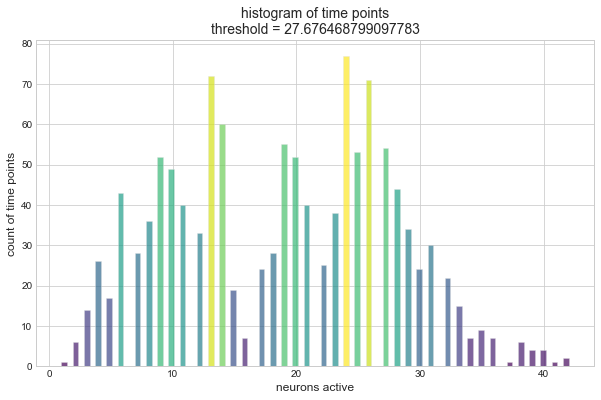

In [7]:
##########define threshold for "high-activity" time points##############################

# for each time point, count how many neurons are active
timePoint_count = np.zeros(np.shape(traces_binar)[1])

for i in range(0, np.shape(traces_binar)[1]):
    count = 0
    
    for j in range(0, np.shape(traces_binar)[0]):
        if traces_binar[j, i] == 1:
            count = count + 1
    
    timePoint_count[i] = count


# define threshold for counts holistically (this could be too stringent and incur selection bias from the end of recording)
mean = np.mean(timePoint_count)
stdv = np.std(timePoint_count)
thresh = mean + stdv

print('threshold for active neurons per time is point set to ' + str(thresh))


# build histogram of time-point counts
fig = plt.figure(figsize=(10,6))
plt.style.use('seaborn-whitegrid')
n, bins, patches = plt.hist(timePoint_count, bins=90, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
n = n.astype('int')

for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))

title = 'histogram of time points'
subtitle = '\nthreshold = ' + str(thresh)
title = title + subtitle

plt.title(title, fontsize=14)
plt.xlabel('neurons active', fontsize=12)
plt.ylabel('count of time points', fontsize=12)
plt.show

In [8]:
##########find graph nodes##############################

range_temp = np.arange(np.shape(traces_binar)[1])
temp_frameIndex = list()
temp_neuronCount = list()

for i in range(0, len(timePoint_count)):
    if timePoint_count[i] > thresh:
        temp_neuronCount.append(timePoint_count[i])
        temp_frameIndex.append(range_temp[i])

graph_nodes_counts = np.zeros((2, len(temp_neuronCount)), dtype='float64')
for i in range(0, len(temp_neuronCount)):
    graph_nodes_counts[0, i] = temp_frameIndex[i]
    graph_nodes_counts[1, i] = temp_neuronCount[i]


# build the time graph
#
#       - remember, order-preserved, member-complete information on the neuron names is stored in traces_names_trimmed
#
#       - remember, order-preserved, member-complete information on the time points to pull is stored in graph_nodes_count[0]
#
#       - for each time point, assemble a k-long array, ...
#               + where we have k-number of neurons
#               + where each element is the binarised activity level of a neuron
#               + e.g. 214 time points * 110 neurons

graph_nodes = np.zeros((np.shape(graph_nodes_counts)[1], np.shape(traces_binar)[0]), dtype='float64')

for i in range(0, np.shape(graph_nodes)[0]): # iterates through time points
    
    for j in range(0, np.shape (graph_nodes)[1]): # iterates through neurons
       graph_nodes[i, j] = traces_binar[j, int(graph_nodes_counts[0, i])]


print('graph-node time indices and counts:')
print(graph_nodes_counts)
print('graph nodes:')
print(graph_nodes)

graph-node time indices and counts:
[[ 481.  482.  484.  485.  486.  487.  488.  490.  491.  494.  744.  745.
   746.  747.  748.  749.  750.  751.  752.  753.  754.  755.  756.  757.
   758.  759.  760.  761.  829.  832.  833.  834.  835.  864.  865.  866.
   877.  878.  879.  880.  881.  882.  883.  884.  885.  896.  897.  898.
   899.  900.  908. 1017. 1018. 1020. 1021. 1032. 1033. 1034. 1035. 1036.
  1037. 1038. 1039. 1040. 1041. 1042. 1043. 1048. 1049. 1065. 1066. 1068.
  1073. 1074. 1075. 1076. 1077. 1078. 1079. 1080. 1081. 1082. 1087. 1088.
  1089. 1090. 1094. 1095. 1101. 1102. 1103. 1104. 1105. 1106. 1107. 1108.
  1109. 1110. 1111. 1112. 1113. 1114. 1115. 1116. 1117. 1118. 1119. 1120.
  1121. 1122. 1123. 1124. 1125. 1126. 1127. 1128. 1129. 1130. 1131. 1132.
  1133. 1134. 1135. 1136. 1137. 1138. 1139. 1140. 1141. 1142. 1143. 1149.
  1150. 1151. 1152. 1153. 1154. 1155. 1156. 1157. 1158. 1159. 1160. 1161.
  1162. 1163. 1164. 1165. 1166. 1167. 1168. 1169. 1170. 1171. 1172. 1173.
  

threshold for displayable edge weight is 0.9125268444500277


<function matplotlib.pyplot.show(close=None, block=None)>

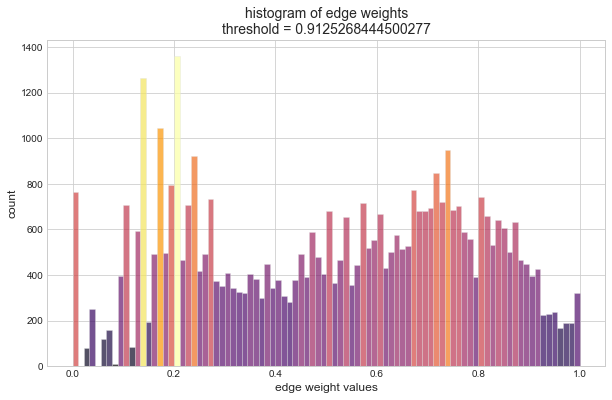

In [9]:
##########find graph weights (undirected)##############################

# calculate cosine distance of non-binarised activity at nodes identified in previous cell
n = np.shape(graph_nodes)[0]
A = np.zeros((n, n), dtype='float64')

for i in range(0, n):
    for j in range(0, n):
        d = 1 - spatial.distance.cosine(graph_nodes[i], graph_nodes[j])
        A[i, j] = d


# set threshold weight as 2 standard deviations above mean
A_temp = A.flatten()

mean = np.mean(A_temp)
stdv = np.std(A_temp)
thresh = mean + (1.5 * stdv)

print('threshold for displayable edge weight is ' + str(thresh))


# build histogram of edge values (bin size = 0.1)
warnings.filterwarnings("ignore",category=plt.cbook.mplDeprecation)

fig = plt.figure(figsize=(10,6))
plt.style.use('seaborn-whitegrid')
n, bins, patches = plt.hist(A_temp, bins=90, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
n = n.astype('int')

for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.inferno(n[i]/max(n)))

title = 'histogram of edge weights'
subtitle = '\nthreshold = ' + str(thresh)
title = title + subtitle

plt.title(title, fontSize=14)
plt.xlabel('edge weight values', fontSize=12)
plt.ylabel('count', fontSize=12)
plt.show

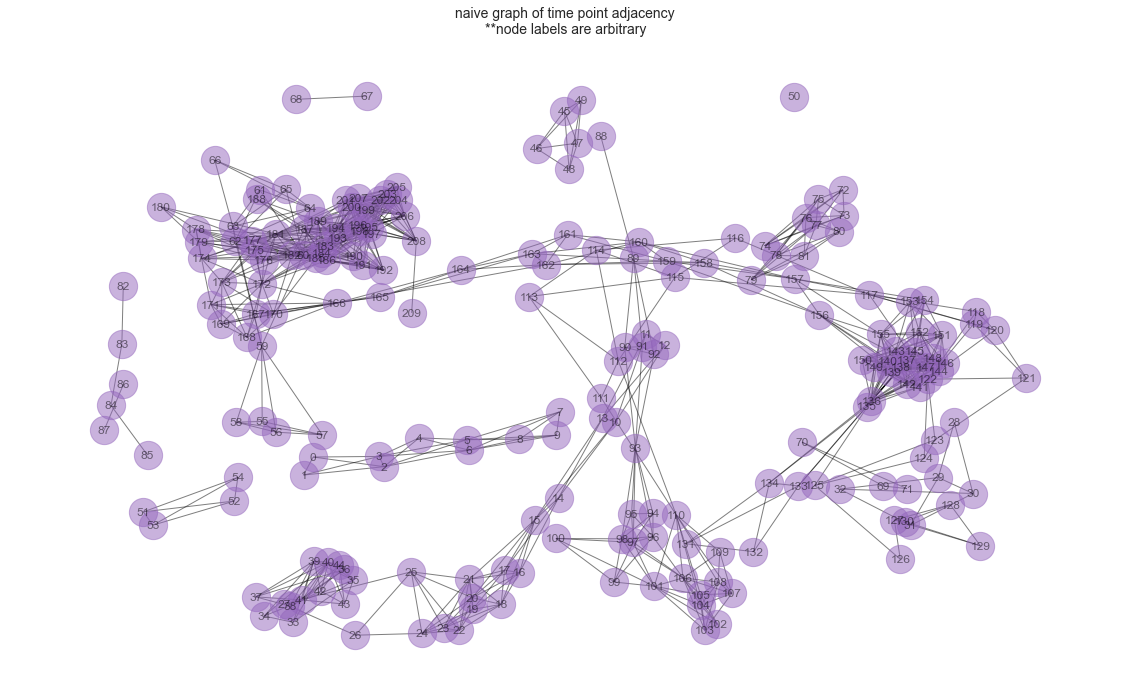

In [10]:
##########plot the naive undirected graph##############################

# "naive graph"
#       - my naive approach to constructing a graph
#       - preserves all connections and weights; i.e.ultra-densely connected
#       - no thresholding of weights in inferring community structure
#       - no calculating of k-nearest neighbor
#       - finding: this graph performs poorly relative to k-nearest neighbor graph
#
# here, we are ommitting the weights from the labelling
#       - for visualization purposes
#
# here, we are presenting a version of the graph with no community structure inference
#       - however, by binarising the weights (A_binar) as per a high threshold...
#       - we are isolating only strong correlations; this could be predictive of community structure
#
# note
#       - node labels are indices within the time array (e.g. indices 0:214)
#       - they must be linked back to the time array to get the actual time nodes when inferring community structure


# binarize A using threshold
A_binar = np.where(A > thresh, 1, 0)
A_binar = A_binar.astype('int8')

# build graph
title = 'naive graph of time point adjacency\n**node labels are arbitrary'

plt.figure(3, figsize=(20,12))
plt.title(title, fontSize=14)
G = nx.from_numpy_matrix(A_binar)
G.remove_edges_from(nx.selfloop_edges(G))

pos = nx.spring_layout(G, k=0.2, iterations=40) # k is internodal distance; iterations is number of times simulated annealing is run
nx.draw(G, pos, node_color='tab:purple', alpha=0.5, node_size=800, with_labels=True)

plt.show()

Clusters: [ 8  5  6  9  3 10 11  4  7  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]


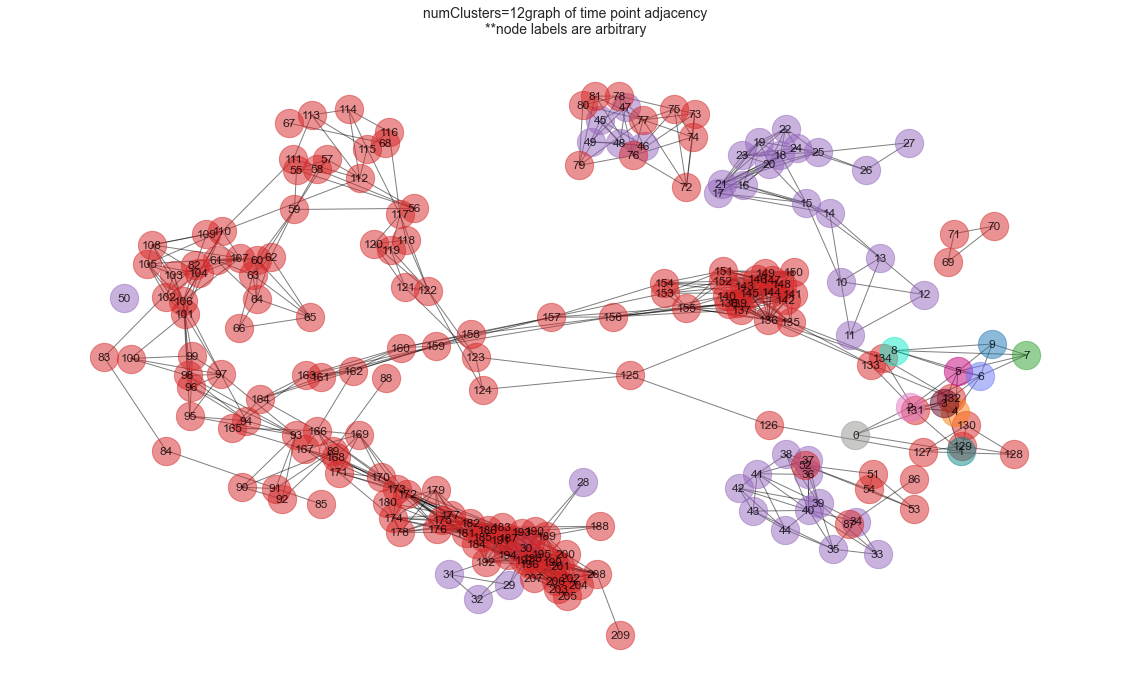

In [11]:
##########try SGC community inference approach##############################

# SGC (spectral graph clustering)
#       - as described in https://towardsdatascience.com/spectral-clustering-aba2640c0d5b


# define number of clusters and graph title
numClusters = 12
title = 'numClusters=' + str(numClusters) + 'graph of time point adjacency\n**node labels are arbitrary'

#perform SGC
colours = SGC(A=A, numClusters=numClusters)

# build clustered graph
plt.figure(3, figsize=(20,12))
plt.title(title, fontSize=14)
G = nx.from_numpy_matrix(A_binar)
G.remove_edges_from(nx.selfloop_edges(G))

pos = nx.spring_layout(G, k=0.2, iterations=40)

colourNames = [
    'tab:purple',
    'tab:red',
    'tab:blue',
    'tab:orange',
    'tab:green',
    'xkcd:dark cyan',
    'tab:pink',
    'xkcd:aqua',
    'xkcd:grey',
    'xkcd:maroon',
    'xkcd:magenta',
    'xkcd:cornflower',
    ]

nodes = np.arange(np.shape(A_binar)[0])

clusters = colourClusters(
    nodes=nodes,
    numClusters=numClusters,
    colours=colours,
    colourNames=colourNames,
    timeIndices=graph_nodes_counts[0]
    )

nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, alpha=0.8)

plt.grid(False)
plt.axis("off")

plt.show()

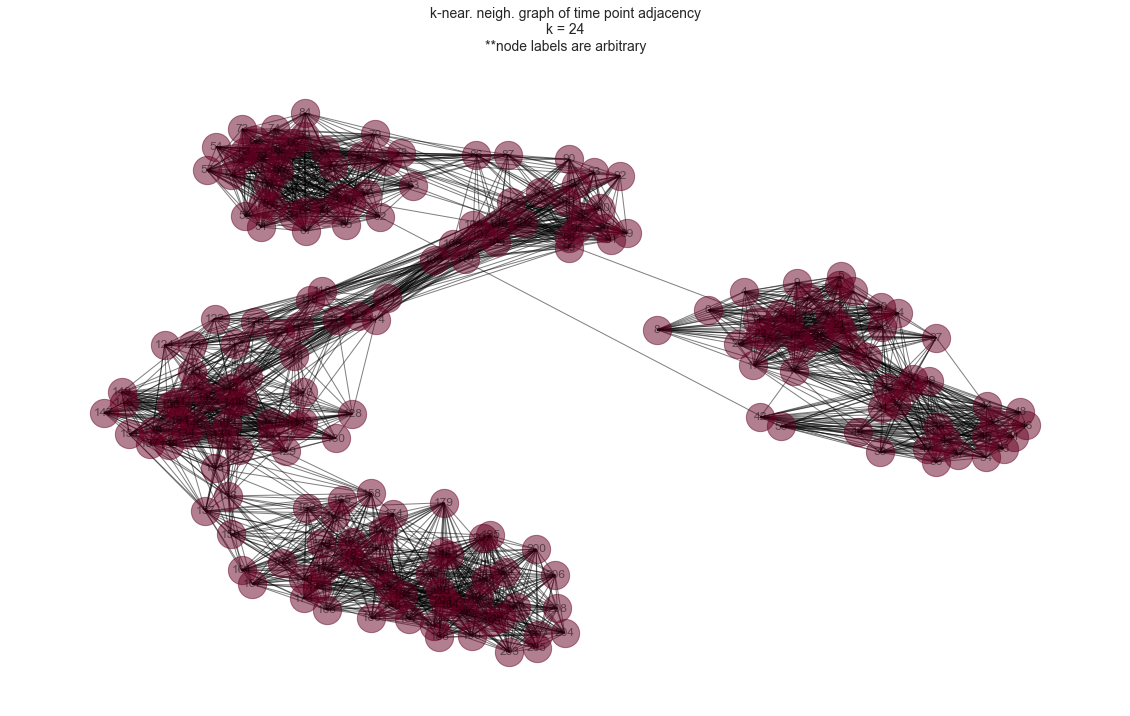

In [12]:
##########find k-nearest-neighbor graph instead##############################

# as prescribed by molter2018:
#       
#       - for finding threshold edge weight
#
#           use unweighted k-nearest neighbor graph
#               k is edge-threshold for whether nodes are connected
#               k is an integer; for each node, the k-nearest neighbors receive an edge
#               start with k = ln(n) and increment by k+=1 until all nodes are connected
# 
#           can build k-nearest-neighbor graph using sklearn.neighbors kneighbors_graph function
#               https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.kneighbors_graph.html
#               takes raw vectors as input rather than adj matrix
#               set n_neighbors=ln(len(graph_nodes_count[0]))
#               set mode:connectivity return adjacency matrix as unweighted
#               set metric="cosine"; uses cosine distance
#               find A=1-A.data to find cosine similarity
#               G = nx.from_scipy_sparse_matrix(A, )

# find k for k-nearest neighbor graph
k = int(math.log(len(graph_nodes_counts[0]))) + 19


# build k-nearest-neighbor scipy matrix object (unweighted, undirected)
A_kn = kneighbors_graph(graph_nodes, k, metric="cosine", mode="connectivity", include_self=True)
A_kn = A_kn.toarray() # nearest neighbors match what's seen in manually computed adjacency matrix
# print(str(np.shape(A_kn)) + '\n', A_kn)
A_kn = A_kn.astype('int8')


# build unweighted k-nearest-neighbor graph
title = 'k-near. neigh. graph of time point adjacency\nk = ' + str(k) + '\n**node labels are arbitrary'


plt.figure(3, figsize=(20,12))
plt.title(title, fontSize=14)
G = nx.from_numpy_matrix(A_kn)
# G = nx.from_scipy_sparse_matrix(A_kn)

G.remove_edges_from(nx.selfloop_edges(G))
pos = nx.spring_layout(G, k=0.2, iterations=20)
nx.draw(G, pos, node_color='xkcd:maroon', alpha=0.5, node_size=800, with_labels=True)

plt.show()


# # find number of clusters
# ###insert code here; there is supposed to be a non-arbitary approach to this when spectral graph is non-obvious

Clusters: [ 6  6  6  6  6  6  6  6  6  6  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  9  9  9  9  9  9  2  2  9  9  9  9  9  9  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  4  8  4  4  4  4  4 11  4  4  4
  4  4  4  4  4 11 11 11 11 11 11 11 11  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  7  7  7  7  7  7  7  7  7  7  7  7
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5 10 10  5 10  5  2 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]


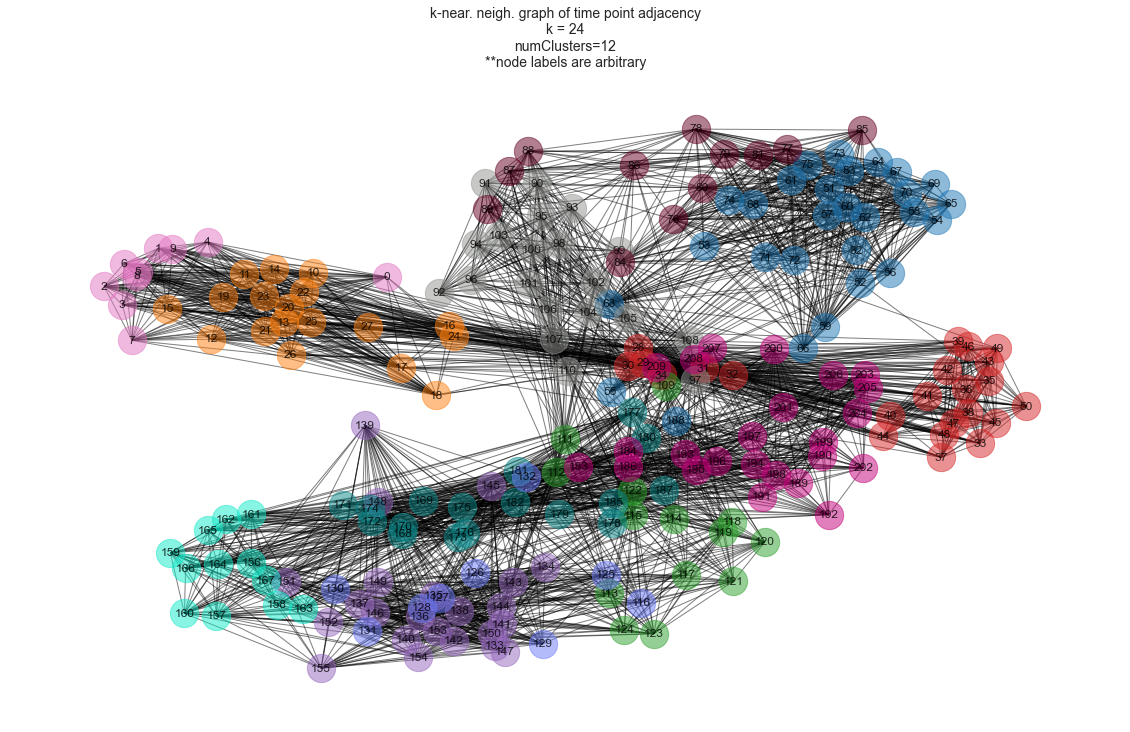

In [19]:
##########perform SGC on KNN graph##############################

# perform SGC
D_kn = np.diag(A_kn.sum(axis=1))
L_kn = D_kn - A_kn

vals_kn, vecs_kn = np.linalg.eigh(L_kn)
vecs_kn = vecs_kn[:, np.argsort(vals_kn)]
vals_kn = vals_kn[np.argsort(vals_kn)]

n_clusters = 12
# @juli: techniques exist to fit a degree-corrected stochastic block to the graph
#       this gives numClusters in a non-arbitrary fashion
#       see molter2018 pg. 14

kmeans_kn = KMeans(n_clusters=n_clusters)
kmeans_kn.fit(vecs_kn[:, 1:n_clusters])
colours_kn = kmeans_kn.labels_

print("Clusters:", colours_kn)

title = 'k-near. neigh. graph of time point adjacency\nk = ' + str(k) + '\nnumClusters=' + str(n_clusters) + '\n**node labels are arbitrary'

plt.figure(3, figsize=(20,12))
plt.title(title, fontSize=14)

G = nx.from_numpy_matrix(A_kn)
G.remove_edges_from(nx.selfloop_edges(G))
pos = nx.spring_layout(G, k=0.1, iterations=10)

nodes_kn = np.arange(np.shape(A_kn)[0])

clusters_kn = colourClusters(
    nodes=nodes_kn,
    numClusters=n_clusters,
    colours=colours_kn,
    colourNames=colourNames,
    timeIndices=graph_nodes_counts[0]
    )

nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, alpha=0.8)

plt.grid(False)
plt.axis("off")

plt.show()

clustered traces stored in var:clusters_traces

data struture: each cluster is a dict with structure neuron_name: nd.array_of_trace


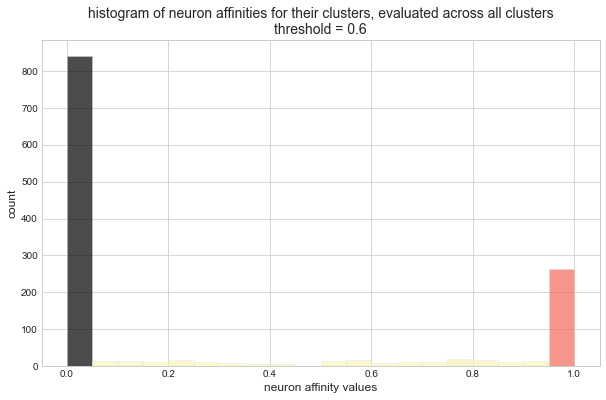

In [14]:
##########find neuroactivity assemblies##############################

# find average activity for each neuron within each time-node cluster
#       - using binarised activity as input
#       - will give value between 0 and 1 ("affinity")
#
# designate affinity threshold e.g. =0.8
#       - neurons with affinity >=threshold get included in neuroactivity assembly
#
# skipping: trimming out some time-node clusters as noise
#
# skipping: merging some time-node clusters together if the high-affinity neurons match close enough
#       - notation for this step in molter2019 is unfollowable
#       - that said, i can probably develop a naive approach of my own if i decide i want to do this


# build time-node clusters from frame-indices specified in clusters_kn
clusteredData_kn = [] # want list of n_clusters nd.arrays, each in turn containing time-node arrays w/ n_neurons elements

for i in range(len(clusters_kn)): # iterates through time-node clusters
    cluster_temp = np.zeros((np.shape(clusters_kn[i])[0], np.shape(graph_nodes)[1]))
    
    for j in range(np.shape(clusters_kn[i])[0]): # iterates through each time node in a cluster
        temp = clusters_kn[i][j]
        l = np.where(graph_nodes_counts[0]==temp)
        l = l[0][0] # pulls time node's index

        cluster_temp[j] = graph_nodes[l] # adds time node to cluster_temp
    
    clusteredData_kn.append(cluster_temp)


# find average of each neuron's element over each time node in each cluster
neuronAffinities = np.zeros((len(clusteredData_kn), np.shape(graph_nodes)[1]))

for i in range(len(clusteredData_kn)): # iterates through each cluster
    
    for j in range(np.shape(graph_nodes)[1]): # iterates through each neuron
        temp = np.zeros(np.shape(clusteredData_kn[i])[0])

        for l in range(np.shape(clusteredData_kn[i])[0]): # iterates through each time node in the cluster
            temp[l] = clusteredData_kn[i][l, j]

        affinity = np.mean(temp)
        neuronAffinities[i, j] = affinity # pulls neuron's affinity for the time-node cluster


# neuronAffinities has shape (n_clusters, n_neurons)
#       - each of n_cluster arrays contains affinity values for each neuron
#       - affinity values are in turn the mean activity of the neuron over each time node in the time-node clusters plotted by KNN graph


# find affininity threshold
affins_temp = neuronAffinities.flatten()
# mean = np.mean(affins_temp)
# stdv = np.std(affins_temp)
thresh_aff = 0.6


# plot histogram of edge weights
warnings.filterwarnings("ignore",category=plt.cbook.mplDeprecation)

fig = plt.figure(figsize=(10,6))
plt.style.use('seaborn-whitegrid')

n, bins, patches = plt.hist(affins_temp, bins=20, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
n = n.astype('int')

for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.magma_r(n[i]/max(n)))

title = 'histogram of neuron affinities for their clusters, evaluated across all clusters'
subtitle = '\nthreshold = ' + str(thresh_aff)
title = title + subtitle

plt.title(title, fontSize=14)
plt.xlabel('neuron affinity values', fontSize=12)
plt.ylabel('count', fontSize=12)
plt.show


# binarise neuronAffinities; set arbitary threshold for affinity
upper = 1
lower = 0
thresh_aff = 0.6

neuronAffinities_binar = np.zeros(np.shape(neuronAffinities), dtype='int8')

for i in range(np.shape(neuronAffinities)[0]):
    temp = np.where(neuronAffinities[i]>=thresh_aff, upper, lower)
    neuronAffinities_binar[i] = temp


# convert neuron_affinities into list of dicts (LD)
#       - where, in each dict, traces_names_trimmed are the keys and neuronAffinities are the values
#       - where there are n_clusters dicts in the list
neuronAffinities_LD = []
for i in range(np.shape(neuronAffinities_binar)[0]): # iterates through clusters
    d = {}
    for G, H in zip(trace_names_trimmed, neuronAffinities_binar[i]): # iterates through neurons
        d[G] = H
    neuronAffinities_LD.append(d)


# remove any elements with value==0 from cluster dicts
neuronAffinities_LD_1s = []
for i in range(len(neuronAffinities_LD)): # iterates through clusters
    d = {G: H for G, H in neuronAffinities_LD[i].items() if H != 0}
    neuronAffinities_LD_1s.append(d)


# store neuron names as list of lists
#       - where outer lists are clusters
#       - where inner lists are neuron names within each cluster
clusters_neurNames = []
for i in range(len(neuronAffinities_LD_1s)):
    l = []
    for G in neuronAffinities_LD_1s[i]:
        l.append(G)
    clusters_neurNames.append(l)


# build list of clusters...
#       - where each cluster is a dict with structure neuron_name: nd.array_of_trace
clusters_traces = []
for cluster in clusters_neurNames:
    d = {}
    for name in cluster:
        i = np.where(trace_names_trimmed == name)
        d[name] = traces_trimmed[i]
    clusters_traces.append(d)


message1 = 'clustered traces stored in var:clusters_traces'
message2 = 'data struture: ' + 'list of clusters, where each cluster is a dict with structure neuron_name: nd.array_of_trace'
message = message1 + '\n\n' + message2
print(message)

1 1 1
1 2 2
2 1 3


ValueError: num must be 1 <= num <= 2, not 3

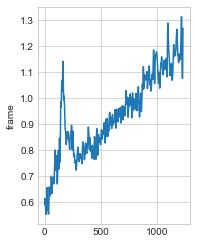

In [51]:
##########plot the clusters given argument##############################

# @user: assign q an int to the cluster you want to plot
#       - e.g. if num_clusters==12, give any int 0:12
q = 0

x = 2
y = 15

# define subplotting helper function to plot each neuron's GCaMP curve
def subplotTrace(row, col, i, neuronName, data, q):

    plt.subplot(row, col, i)
    plt.plot(data[q][neuronName][0])
    plt.title = neuronName

    plt.ylabel('frame')

    if (i % 2) == 1:
        plt.ylabel('GCaMP')

    return None


# generate plot for cluster
for j in range(len(clusters_traces[q])):
    i = j + 1
    col = j % 2 + 1
    row = int(np.ceil(i/2))

    print(row, col, i)

    key = list(clusters_traces[q].keys())[i]
    subplotTrace(row=row, col=col, i=i, neuronName=key, data=clusters_traces, q=q)

plt.show()

    














In [39]:
##########debug console##############################
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(suppress=True)


# print(np.shape(trace_names_trimmed), '\n', np.shape(traces_trimmed))
# print(clusters_traces)
list(clusters_traces[0].keys())[0]
9 % 2 + 3

# print(len(clusters_traces)) # should return 12
# print(len(clusters_traces[0])) # should return some n1
# print(len(clusters_traces[5])) # should return some n2, where n1 != n2
# print(np.shape(clusters_traces[0]['Na24'][0])) # should equal (1230,)

4

In [17]:
# notes on naive-graph eigenvalues here
#       - only one eigenvalue close to zero
#       - rest show gradual change from 1.3e+03 to 1.8e+02
#       - suggests there is no neat way to cluster this data as it stands; this might make sense, as the graph is heavily densely connected
#       - (bear in mind, the figure displays only a minority of the edges; in fact there are multitudes more that are not displayed in the naive-graph figures)
#       - soln1: threshold out most connections, e.g. by using A_binar, to improve clustering
#       - soln2: use unweighted k-nearest-neioghbor graph, as molter 2018 originally recommends (see later 2 graphs)

# general notes on time-cluster performance
#       - the prevailing variable driving time-node similarity is time proximity
#       - i.e. time nodes that are close in time (e.g. t=1009 and t=1007) get clustered together
#       - i.e. time nodes that are far in time (e.g. t=1009 and t=422) get clustered apart
#       - this may mean that the entire analysis strategy will fail to find meaningful neuroactivity relationships
#       - soln1: disable low-pass filtering in the original input traces (futile soln)
#       - soln2: sink into despair and divest yourself from all Apollonian aspirations (existential soln)
#       - soln3: read the next paragraphs of molter 2018, which describes how they brutalized their data until they output relationships they liked (actual soln?)


'''
concerns

1.      in selecting only those time points that have a certain n neurons active...
                we are biasing selection to frames at the end of recording
                i.e. information at the beginning of the recording will not be incorporated into the graph
 

        soln? debleach the traces better (TRY SECOND)
        - this could flatten the "null rise" traces
        - will have to check how to tailor the debleach curve-fitting window to each trace individiually
        - okay i tried this and i cannot for the life of me get mahdi's denoising approach to do this properly


        soln? manually remove some traces from analysis (TRY FIRST)
        - manually remove traces that exhibit "null rise" pattern
        - i.e. Na135, Na138, etc.



2.      currently we have a graph with 214 nodes;
                is it computationally gentle to calculate the cosine similarity (i.e. edges) on 214^2 pairs?
                apparently yes; my desktop CPU does it in 1.8s


        soln? use a more stringent threshold to reduce number of nodes (TRY SECOND)
        - this won't help bc            it will exacerbate the selection bias problem described in 1.
        - this could help if            we solve the selection problem


        soln? perform  analysis separately on each ganglion (TRY FIRST)
        - requires generating a dataset for each ganglion and iterating this script on each
        - problem is we will lose out on relationships that persist across ganglia
        - still, it could help prove that this analysis works
        - this could help bc            it will reduce the nodes in the graph, and the number of cuts necessary to cluster
        - this could help bc            for some ganglia, there will be few traces with "null rise" pattern likely due to bleaching


3.      need to automate saving output
        - includes saving figures as .svg rather than .png
'''

'\nconcerns\n\n1.      in selecting only those time points that have a certain n neurons active...\n                we are biasing selection to frames at the end of recording\n                i.e. information at the beginning of the recording will not be incorporated into the graph\n \n\n        soln? debleach the traces better (TRY SECOND)\n        - this could flatten the "null rise" traces\n        - will have to check how to tailor the debleach curve-fitting window to each trace individiually\n        - okay i tried this and i cannot for the life of me get mahdi\'s denoising approach to do this properly\n\n\n        soln? manually remove some traces from analysis (TRY FIRST)\n        - manually remove traces that exhibit "null rise" pattern\n        - i.e. Na135, Na138, etc.\n\n\n\n2.      currently we have a graph with 214 nodes;\n                is it computationally gentle to calculate the cosine similarity (i.e. edges) on 214^2 pairs?\n                apparently yes; my desktop